In [1]:
# %%html
# <style>
#     #notebook-container{
#     width: 100%
#     }
# </style>

In [2]:
#install statsmodel version 0.11 since colab doesn't have it by default
!pip install statsmodels==0.11.0 
!pip install graphviz

In [3]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stat
import math
import rpy2.robjects as robjects
import graphviz
import sklearn

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import model_selection
from scipy import stats
from sklearn.svm import SVR
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn import tree
from graphviz import Digraph
from statsmodels.nonparametric.kernel_regression import KernelReg

sns.set()

In [4]:
# telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Statistic/master/telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2. The variable "tenure" is taken as the dependent variable and the remaining variables as explanatory. <br>

## Subtask 1.

The lasso regression is an alternative approach to variable selection. <br>

### Part (a)
Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

Idea of Lasso regression is not only found a suitable model, but also perform feature selection at the same time. This is possible because Lasso regression using L1 norm for the constraint region. By doing this in 2D example we will get constraints in shape of diamond and contours lines drawn around OLS solution will intersect with constraints in one of the vertex of this diamond. Please refer to the picture below. This allow to perform feature selection by setting not important variables to 0. On the picture below this will be wariable $w_1$ which will be set to 0. 

![Image: diamond shape of constraints for Lasso](https://drive.google.com/uc?id=18zYMTZW_rrZbRyPfSqoriCq5yQOjOUvK)

Lasso regression technique works well for cases with a lot of variables and allow to simplify models by dropping not important features from final model.

Simple linear regression will behave poorly on the data which is centered around mean value (for example 0 as mean value or any other mean value like 10 below). Below I tried to simulate such data - it is data which is centered around 10 as mean, but it is highly skewed in vertical direction. As result linear regression line describes such data poorly. Same I think will be with data in form of circle, as another example. 

On opposite, Lasso regression we could apply here and it will give us better results. But for this we need to center our data around 0 as mean and scale it so it could fir Lasso constraints region in shape of diamond as highlighted above.

(9, 11)

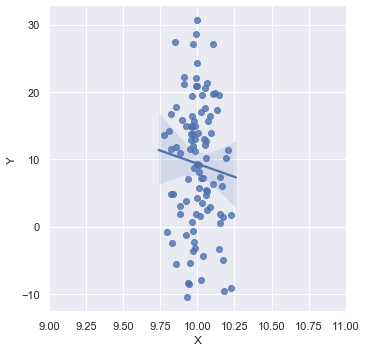

In [5]:
np.random.seed(7)

X = np.random.normal(10, 0.1, 100) #simulating data which for which linear regression will behave poorly
Y = np.random.normal(10, 10, 100)

df = pd.DataFrame({'X': X, 'Y': Y})

sns.lmplot(x='X', y='Y', data = df) #ploting linear regression plot
plt.xlim((9,11))

### Part (b)

For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \bar x)/\hat \sigma_x$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable "ed"?

For Lasso regression scaling of data become crucial because independent variables should be centered around 0 (have mean of 0). Because of this reason we perform scaling of data as per formula $\frac{(x_i - \bar x)}{\hat \sigma_x}$. Without scaling Lasso regression would provide a wrong results - countours of Least Square solution will intersect with non-scaled data in different points than it should. <br>

As for binary variables - those should be scaled as well. Otherwise for such variables like "gender" mean value will be around 0.5 and not 0 as it should be. Same holds for other binary variables - mean value is not equal to 0 as result Lasso regression will produce wrong results. Hence, I am also scaling all dummy variables to center those around mean of 0. <br>

For variable "ed", in addition to scaling, we also need to group all education related dummy variables and perform group Lasso regression which keeps related dummy variables as single group. In such case either none or all of such variables are excluded. Grouped dummy variables could not be excluded partially.

In [6]:
telco_df_norm = telco_df.copy() #scaling data

telco_df_norm.tenure = (telco_df_norm.tenure-telco_df_norm.tenure.mean()) / telco_df_norm.tenure.std()
telco_df_norm.age = (telco_df_norm.age-telco_df_norm.age.mean()) / telco_df_norm.age.std()
telco_df_norm.address = (telco_df_norm.address-telco_df_norm.address.mean()) / telco_df_norm.address.std()
telco_df_norm.income = (telco_df_norm.income-telco_df_norm.income.mean()) / telco_df_norm.income.std()
telco_df_norm.employ = (telco_df_norm.employ-telco_df_norm.employ.mean()) / telco_df_norm.employ.std()
telco_df_norm.longmon = (telco_df_norm.longmon-telco_df_norm.longmon.mean()) / telco_df_norm.longmon.std()
telco_df_norm.wiremon = (telco_df_norm.wiremon-telco_df_norm.wiremon.mean()) / telco_df_norm.wiremon.std()

telco_df_norm.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00


In [7]:
telco_df_norm_dummy = telco_df_norm.copy()

telco_df_norm_dummy = pd.get_dummies(telco_df_norm, columns=(['marital', 'retire', 'gender', 'churn', 'ed'])) #creating dummy variables for categorical data

telco_df_norm_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No',  #drop part of dummy variables and rename remaning
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_norm_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_norm_dummy.marital_dummy = (telco_df_norm_dummy.marital_dummy-telco_df_norm_dummy.marital_dummy.mean()) / telco_df_norm_dummy.marital_dummy.std() #scaling created dummy variables
telco_df_norm_dummy.retire_dummy = (telco_df_norm_dummy.retire_dummy-telco_df_norm_dummy.retire_dummy.mean()) / telco_df_norm_dummy.retire_dummy.std()
telco_df_norm_dummy.gender_dummy = (telco_df_norm_dummy.gender_dummy-telco_df_norm_dummy.gender_dummy.mean()) / telco_df_norm_dummy.gender_dummy.std()
telco_df_norm_dummy.churn_dummy = (telco_df_norm_dummy.churn_dummy-telco_df_norm_dummy.churn_dummy.mean()) / telco_df_norm_dummy.churn_dummy.std()
telco_df_norm_dummy.ed_dummy_college_degree = (telco_df_norm_dummy.ed_dummy_college_degree-telco_df_norm_dummy.ed_dummy_college_degree.mean()) / telco_df_norm_dummy.ed_dummy_college_degree.std()
telco_df_norm_dummy.ed_dummy_no_high_school = (telco_df_norm_dummy.ed_dummy_no_high_school-telco_df_norm_dummy.ed_dummy_no_high_school.mean()) / telco_df_norm_dummy.ed_dummy_no_high_school.std()
telco_df_norm_dummy.ed_dummy_high_school = (telco_df_norm_dummy.ed_dummy_high_school-telco_df_norm_dummy.ed_dummy_high_school.mean()) / telco_df_norm_dummy.ed_dummy_high_school.std()
telco_df_norm_dummy.ed_dummy_some_college = (telco_df_norm_dummy.ed_dummy_some_college-telco_df_norm_dummy.ed_dummy_some_college.mean()) / telco_df_norm_dummy.ed_dummy_some_college.std()

telco_df_norm_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16,9.992007e-17,-1.318390e-16,-2.435829e-16,6.616929e-17,-8.992806e-17,-1.403322e-16,1.296740e-16,1.183498e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01,1.009545e+00,-2.219654e-01,1.034081e+00,1.626956e+00,-5.524288e-01,-5.059893e-01,1.575384e+00,-5.137687e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00,1.009545e+00,4.500702e+00,1.034081e+00,1.626956e+00,1.808378e+00,1.974350e+00,1.575384e+00,1.944455e+00


### Part (c)

Run a lasso regression for data with $\lambda \in (0, 1)$. Plot the estimated parameters as functions of $\lambda$. Which value of $\lambda$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

For alpha=0.80000
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79900
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79800
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79700
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79600
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79500
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79400
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79300
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79200
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79100
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79000
Training score: 0.00000
Test score: -0.02047
Number of feature

For alpha=0.69400
Training score: 0.05847
Test score: 0.03206
Number of features used: 1 

For alpha=0.69300
Training score: 0.05974
Test score: 0.03321
Number of features used: 1 

For alpha=0.69200
Training score: 0.06100
Test score: 0.03435
Number of features used: 1 

For alpha=0.69100
Training score: 0.06227
Test score: 0.03550
Number of features used: 1 

For alpha=0.69000
Training score: 0.06353
Test score: 0.03664
Number of features used: 1 

For alpha=0.68900
Training score: 0.06480
Test score: 0.03779
Number of features used: 1 

For alpha=0.68800
Training score: 0.06606
Test score: 0.03893
Number of features used: 1 

For alpha=0.68700
Training score: 0.06731
Test score: 0.04007
Number of features used: 1 

For alpha=0.68600
Training score: 0.06857
Test score: 0.04121
Number of features used: 1 

For alpha=0.68500
Training score: 0.06983
Test score: 0.04235
Number of features used: 1 

For alpha=0.68400
Training score: 0.07108
Test score: 0.04349
Number of features used: 1 


For alpha=0.59000
Training score: 0.18069
Test score: 0.14461
Number of features used: 1 

For alpha=0.58900
Training score: 0.18177
Test score: 0.14562
Number of features used: 1 

For alpha=0.58800
Training score: 0.18284
Test score: 0.14664
Number of features used: 1 

For alpha=0.58700
Training score: 0.18392
Test score: 0.14765
Number of features used: 1 

For alpha=0.58600
Training score: 0.18499
Test score: 0.14866
Number of features used: 1 

For alpha=0.58500
Training score: 0.18606
Test score: 0.14967
Number of features used: 1 

For alpha=0.58400
Training score: 0.18713
Test score: 0.15068
Number of features used: 1 

For alpha=0.58300
Training score: 0.18820
Test score: 0.15168
Number of features used: 1 

For alpha=0.58200
Training score: 0.18927
Test score: 0.15269
Number of features used: 1 

For alpha=0.58100
Training score: 0.19033
Test score: 0.15369
Number of features used: 1 

For alpha=0.58000
Training score: 0.19140
Test score: 0.15470
Number of features used: 1 


For alpha=0.49400
Training score: 0.27593
Test score: 0.23612
Number of features used: 1 

For alpha=0.49300
Training score: 0.27684
Test score: 0.23701
Number of features used: 1 

For alpha=0.49200
Training score: 0.27774
Test score: 0.23790
Number of features used: 1 

For alpha=0.49100
Training score: 0.27864
Test score: 0.23879
Number of features used: 1 

For alpha=0.49000
Training score: 0.27954
Test score: 0.23968
Number of features used: 1 

For alpha=0.48900
Training score: 0.28043
Test score: 0.24056
Number of features used: 1 

For alpha=0.48800
Training score: 0.28133
Test score: 0.24144
Number of features used: 1 

For alpha=0.48700
Training score: 0.28222
Test score: 0.24233
Number of features used: 1 

For alpha=0.48600
Training score: 0.28311
Test score: 0.24321
Number of features used: 1 

For alpha=0.48500
Training score: 0.28400
Test score: 0.24409
Number of features used: 1 

For alpha=0.48400
Training score: 0.28489
Test score: 0.24497
Number of features used: 1 


For alpha=0.39300
Training score: 0.35793
Test score: 0.31956
Number of features used: 1 

For alpha=0.39200
Training score: 0.35865
Test score: 0.32032
Number of features used: 1 

For alpha=0.39100
Training score: 0.35937
Test score: 0.32108
Number of features used: 1 

For alpha=0.39000
Training score: 0.36008
Test score: 0.32184
Number of features used: 1 

For alpha=0.38900
Training score: 0.36079
Test score: 0.32260
Number of features used: 1 

For alpha=0.38800
Training score: 0.36150
Test score: 0.32335
Number of features used: 1 

For alpha=0.38700
Training score: 0.36221
Test score: 0.32411
Number of features used: 1 

For alpha=0.38600
Training score: 0.36292
Test score: 0.32486
Number of features used: 1 

For alpha=0.38500
Training score: 0.36363
Test score: 0.32561
Number of features used: 1 

For alpha=0.38400
Training score: 0.36433
Test score: 0.32636
Number of features used: 1 

For alpha=0.38300
Training score: 0.36503
Test score: 0.32711
Number of features used: 1 


For alpha=0.29200
Training score: 0.44599
Test score: 0.41245
Number of features used: 4 

For alpha=0.29100
Training score: 0.44686
Test score: 0.41339
Number of features used: 4 

For alpha=0.29000
Training score: 0.44773
Test score: 0.41433
Number of features used: 4 

For alpha=0.28900
Training score: 0.44859
Test score: 0.41526
Number of features used: 4 

For alpha=0.28800
Training score: 0.44945
Test score: 0.41619
Number of features used: 4 

For alpha=0.28700
Training score: 0.45031
Test score: 0.41711
Number of features used: 4 

For alpha=0.28600
Training score: 0.45117
Test score: 0.41804
Number of features used: 4 

For alpha=0.28500
Training score: 0.45202
Test score: 0.41896
Number of features used: 4 

For alpha=0.28400
Training score: 0.45287
Test score: 0.41988
Number of features used: 4 

For alpha=0.28300
Training score: 0.45372
Test score: 0.42080
Number of features used: 4 

For alpha=0.28200
Training score: 0.45457
Test score: 0.42172
Number of features used: 4 


For alpha=0.19100
Training score: 0.51889
Test score: 0.49482
Number of features used: 4 

For alpha=0.19000
Training score: 0.51946
Test score: 0.49552
Number of features used: 4 

For alpha=0.18900
Training score: 0.52003
Test score: 0.49620
Number of features used: 4 

For alpha=0.18800
Training score: 0.52059
Test score: 0.49689
Number of features used: 4 

For alpha=0.18700
Training score: 0.52115
Test score: 0.49758
Number of features used: 4 

For alpha=0.18600
Training score: 0.52171
Test score: 0.49826
Number of features used: 4 

For alpha=0.18500
Training score: 0.52226
Test score: 0.49894
Number of features used: 4 

For alpha=0.18400
Training score: 0.52282
Test score: 0.49961
Number of features used: 4 

For alpha=0.18300
Training score: 0.52336
Test score: 0.50029
Number of features used: 4 

For alpha=0.18200
Training score: 0.52391
Test score: 0.50096
Number of features used: 4 

For alpha=0.18100
Training score: 0.52445
Test score: 0.50163
Number of features used: 4 


For alpha=0.08600
Training score: 0.57878
Test score: 0.57865
Number of features used: 7 

For alpha=0.08500
Training score: 0.57943
Test score: 0.57933
Number of features used: 7 

For alpha=0.08400
Training score: 0.58007
Test score: 0.58000
Number of features used: 7 

For alpha=0.08300
Training score: 0.58070
Test score: 0.58067
Number of features used: 7 

For alpha=0.08200
Training score: 0.58133
Test score: 0.58133
Number of features used: 7 

For alpha=0.08100
Training score: 0.58195
Test score: 0.58198
Number of features used: 7 

For alpha=0.08000
Training score: 0.58256
Test score: 0.58262
Number of features used: 7 

For alpha=0.07900
Training score: 0.58317
Test score: 0.58326
Number of features used: 7 

For alpha=0.07800
Training score: 0.58376
Test score: 0.58389
Number of features used: 7 

For alpha=0.07700
Training score: 0.58435
Test score: 0.58451
Number of features used: 7 

For alpha=0.07600
Training score: 0.58493
Test score: 0.58513
Number of features used: 7 


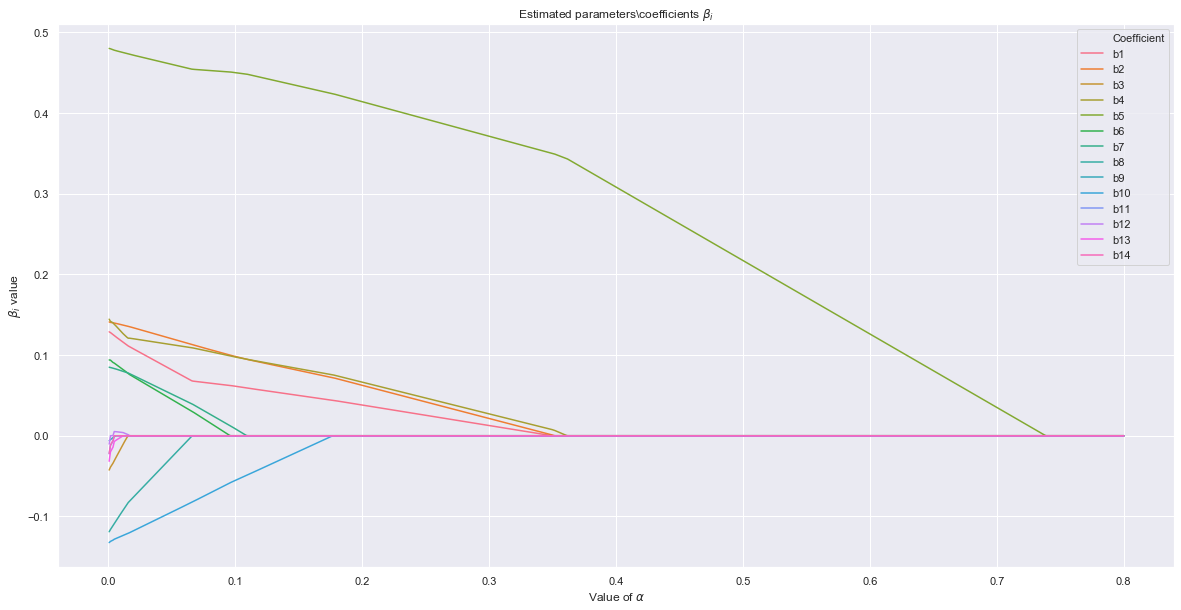

In [8]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure']) #preparing data
Y = telco_df_norm_dummy.copy().tenure

lambdas = np.arange(0.8, 0, -0.001) #cosndidering different values of lambda
coefficients = []

for lambd in lambdas: #performing multiple Lasso regression with different lambda
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y, test_size=0.3, random_state=7)

    lasso = linear_model.Lasso(alpha=lambd) #calculating train and test score for each lambda. Also calcualting amount of features used
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    coefficients.append(lasso.coef_)

    print("For alpha=%.5f" %lambd)
    print("Training score: %.5f" %train_score )
    print("Test score: %.5f" %test_score)
    print("Number of features used: %s \n" %coeff_used)
    

coefficients_df = pd.DataFrame(coefficients, columns=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14"]) #preparing data for plotting
coefficients_df['alpha'] = lambdas
coefficients_df = coefficients_df.melt(id_vars=['alpha'], var_name='Coefficient')
coefficients_df.tail()

plt.figure(figsize=(20,10)) # plotting values of all coefficients based on lambda value
ax = sns.lineplot(x="alpha", y="value", hue="Coefficient", data=coefficients_df, )
plt.title("Estimated parameters\coefficients $\\beta_i$")
plt.ylabel("$\\beta_i$ value")
plt.xlabel("Value of $\\alpha$")
plt.show()

From this plot and printed test errors we could see that more or less accuracy of 61% achieved around $\lambda = 0.03$ so it make sense to recommend this value. Also with this values of $\lambda$ there is only 8 non-zero features coefficients and others are zeroed out. Now I would try to find optimal values of $\lambda$ by cross-validation.

In [9]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure']) #preparing data
Y = telco_df_norm_dummy.copy().tenure

lassoCV = linear_model.LassoCV(cv=15, random_state=7) #fitting Lasso Cross-Validation model to find optimal lambda
lassoCV.fit(X, Y)

print("Final score of CV: %.5f" %lassoCV.score(X, Y)) #printing results
print("Optimal value of found by CV lambda = %.5f" %lassoCV.alpha_)
print("Optimal coefficients found by CV: %s" %lassoCV.coef_.round(5))

Final score of CV: 0.62021
Optimal value of found by CV lambda = 0.01162
Optimal coefficients found by CV: [ 0.09673  0.1427  -0.       0.11734  0.51164  0.05954  0.06464 -0.08162
 -0.0027  -0.1452  -0.00884  0.      -0.      -0.     ]


Optimal value of $\lambda$ found by Cross Validation is $\lambda=0.01162$.

## Subtask 2.

A nonlinear regression oﬀers a ﬂexible technique for modelling complex relationships. We wish to explain the "tenure" by the long distance calls per month "longmon". <br>

### Part (a)

Make a bivariate scatter plot and estimate an appropriate linear model. Add the regression line to the plot. 

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


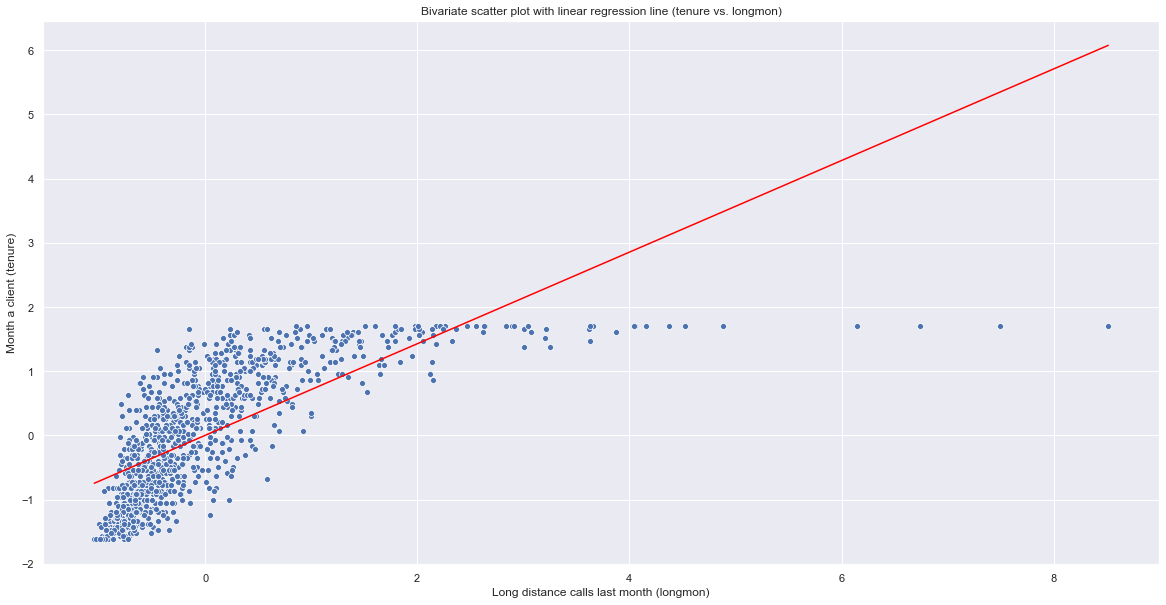

Adjusted R2 score of linear model: 0.50884
Root Mean Square Error (RMSE) of linear model: 0.70012


In [10]:
X = telco_df_norm_dummy.copy().longmon #preparing data for regression
X = sm.add_constant(X)
Y = telco_df_norm_dummy.copy().tenure

result = sm.OLS(Y , X).fit() #fitting linear regression

Y_pred_man = np.dot(X, result.params)

plt.figure(figsize=(20,10)) #plotting results
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=Y_pred_man, color='red')
plt.title("Bivariate scatter plot with linear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - result.fittedvalues)**2).mean()) #calculating linear model RMSE
print("Adjusted R2 score of linear model: %.5f" %result.rsquared_adj) #orinting results
print("Root Mean Square Error (RMSE) of linear model: %.5f" %rmse)

### Part(b)

Estimate now an appropriate nonlinear regression which might ﬁt the data better. Add the regression curve to the plot and compare (quantitatively) the ﬁt with the ﬁt of the linear model. 

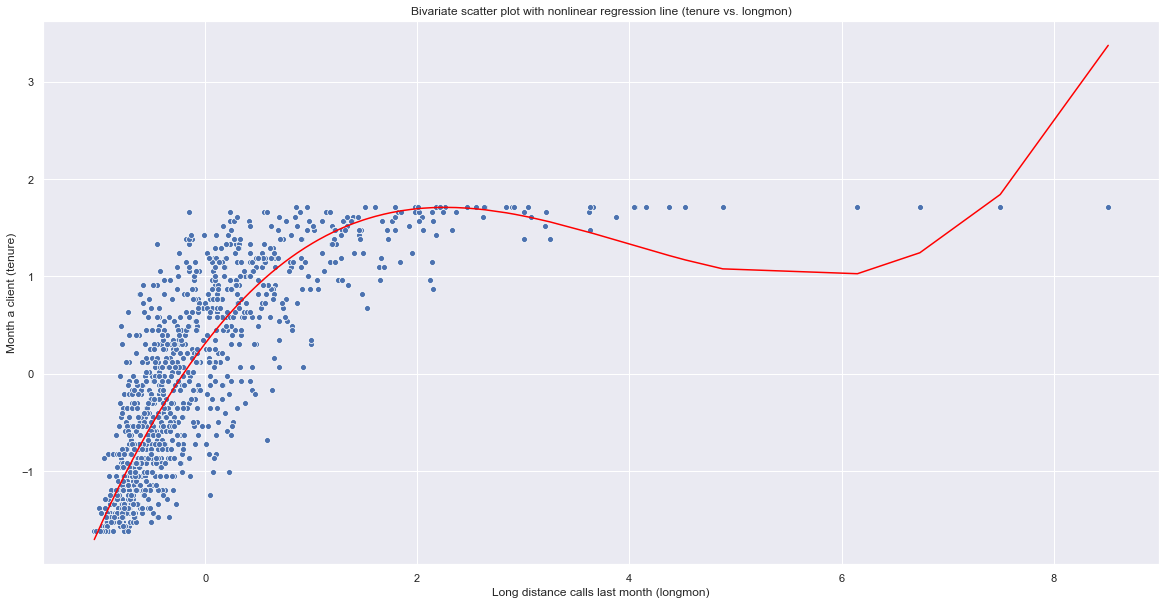

R2 score of nonlinear model: 0.71297
Root Mean Square Error (RMSE) of nonlinear model: 0.53548


In [11]:
X = telco_df_norm_dummy.copy().longmon #preparing data for regression
X = X.to_numpy().reshape(-1, 1)
Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1) #performing non-linear regression using SVM
model.fit(X,Y)

plt.figure(figsize=(20,10)) #plotting results
sns.scatterplot(x=X.reshape(-1), y=telco_df_norm_dummy.tenure)
sns.lineplot(x=X.reshape(-1), y=model.predict(X), color='red')
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean()) #calculating RMSE of non-linear model
print("R2 score of nonlinear model: %.5f" %model.score(X,Y)) #printing results
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

To compare linear regression fit with nonlinear one numerically we could use Root Mean Square Error (RMSE) value of both models. I have calcualted it for each model by subtracting predicted value from real one, then square difference, calculate mean of all squared deviations and take square root from mean in the end. Since RMSE of linear model is 0.70012 and RMSE of nonlinear model is 0.53548 we could conclude that non-linear model fits given data better.

### Part (c)

Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.

Classical test and inferences assume normal distribution of observations (or errors). However, in case of NLS estimators distribution of model errors is not normal one. Hence those tests and inferences are not directly applicable to NLS estimators. Resulting $\hat \beta$ is not a linear function of residuals $u_k$, because of this $\hat \beta$ has non-linear distribution. But still Maximum Likelihood (ML) estimators are consistent and efficient for NLS because they have smallest variance among all estimators (best of what we can get). All tests and inferences valid only asymptotically.

### Part (d)

What kind of problems might arise if we decide to ﬁt a non-linear regression using all explanatory variables?

In case if we will decide to fit nonlinear regression using all explanatory variables we will end up with very complex nonlinear function. Below I have visualize same plot as above, but model was fitted to all variables and not only to "longmon". As you could see - function is extremly complex in such case. It is impossible to find manually such complex function. Another issue - function is definetly overfitted with regards to training data. Most probably such model will behave badly on unseen (test) data. Also, such higly nonlinear systems could be solved only numerically - no exact solution exist.

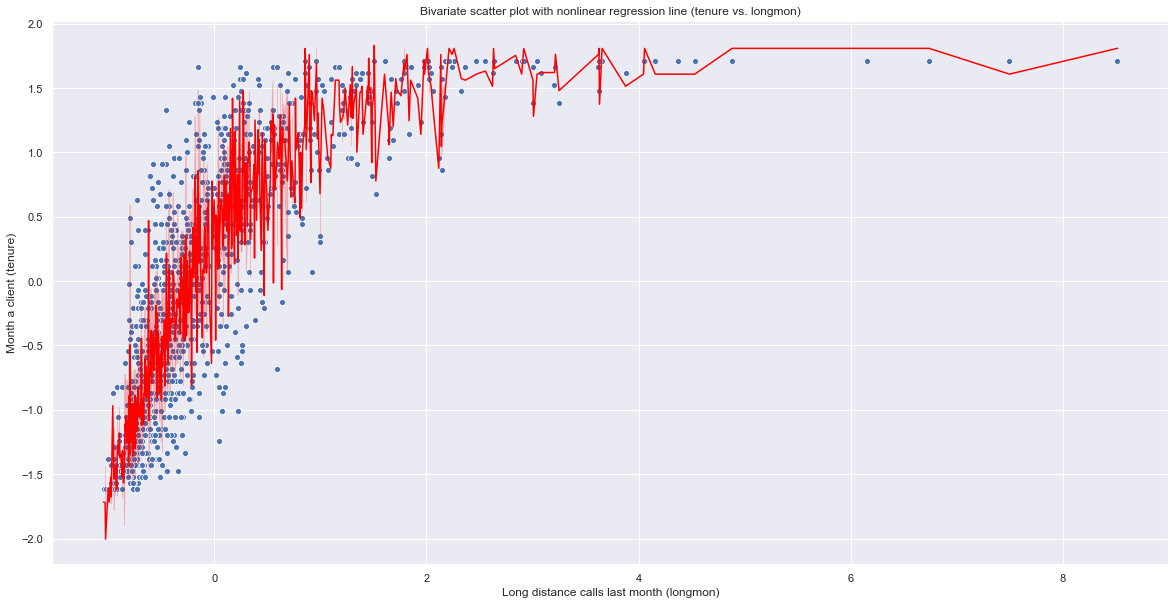

R2 score of nonlinear model: 0.84106
Root Mean Square Error (RMSE) of nonlinear model: 0.39847


In [12]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure']) #preparing data

Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1) #fitting non-linear model for multiple features
model.fit(X,Y)

plt.figure(figsize=(20,10)) #plotting the result
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=model.predict(X), color='red')
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean()) #calculating RMSE for non-linear model with all independent variables
print("R2 score of nonlinear model: %.5f" %model.score(X,Y)) #printing results
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

## Subtask 3.

Next we model the relationship between "tenure" and "longmon" using the nonparametric Nadaraya-Watson regression.

### Part (a)

An important calibration parameter of a nonparametric regression is the bandwidth. Explain what happens with the regression/the weights in the Nadaraya-Watson regression if the bandwidth is too high or too small.

All Kernel Density Estimators heavily depends on bandwith $h$ and Nadaraya-Watson regression is not an exclusion here. Kernels are window functions width of which are set by bandwith parameter. So with $h \rightarrow \inf$ kernel will include all points with equal weights and regression will look like linear regression. On opposite, if $h$ is small - then model will fit values locally, means it will fit mean to each point individually. So bandwith $h$ determines how local kernel density estimator with regards to points $X_i$.

### Part (b)

Fit a Nadaraya-Watson regression with Gaussian kernel and “optimal” bandwidth to the "longmon"/"tenure" data. Check and explain how the “optimal bandwidth” is determined in your software. Compare the (in-sample) ﬁt of the nonparametric regression and the nonlinear regression in the previous subproblem.

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:251: RuntimeWarning: invalid value encountered in true_divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


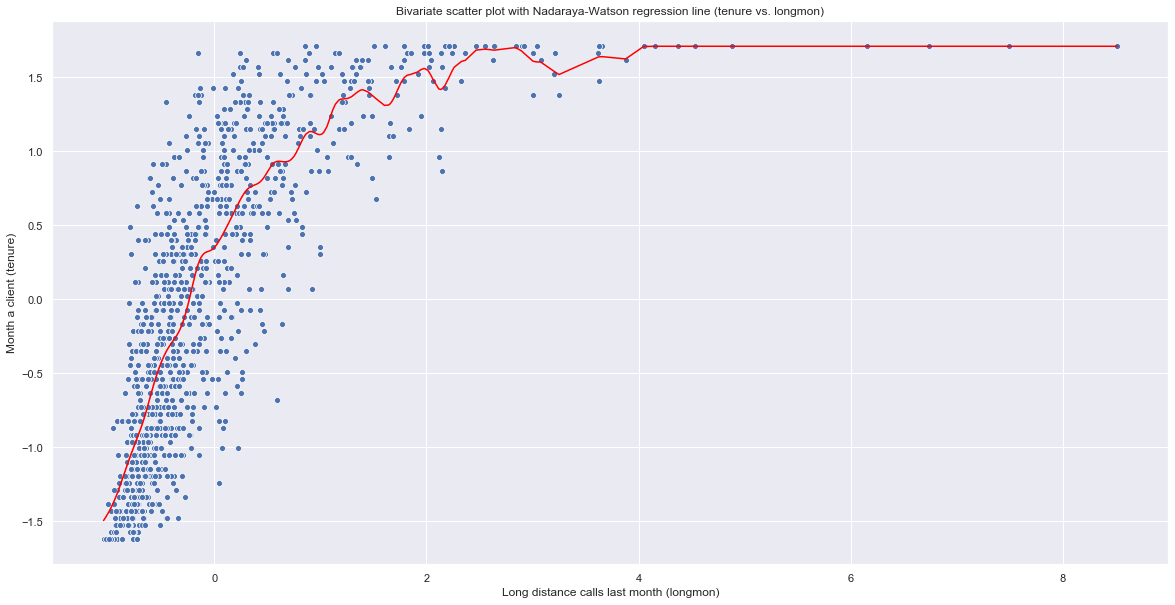

R2 score of Nadaraya-Watson model: 0.72775
Root Mean Square Error (RMSE) of nonlinear model: 0.52171


In [13]:
X = telco_df_norm_dummy.copy().longmon #preparing data
Y = telco_df_norm_dummy.copy().tenure

NWmodel = KernelReg(endog=Y, exog=X, var_type='c', ckertype='gaussian', reg_type='lc', bw='cv_ls') #fitting Nadaraya-Watson model

plt.figure(figsize=(20,10)) #plotting results
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=NWmodel.fit(X)[0], color='red')
plt.title("Bivariate scatter plot with Nadaraya-Watson regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - NWmodel.fit(X)[0])**2).mean()) #calculating non-paramethric model RMSE
print("R2 score of Nadaraya-Watson model: %.5f" %NWmodel.r_squared()) #printing results
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

I've used Least Square Cross Validation (LSCV) method for optimal bandwith selection. Idea behind this method is to compare target value with leave-one-out estimator on each step to recieve least squares cross-validation error. Then final optimal bandwith value will be such value of bandwith for which least squares cross-validation error reach it global minimum value.

Comparing $R^2$ score and RMSE of Nadaraya-Watson (NW) model with nonlinear model we could see that NW model is sligntly better - it has higher $R^2$ score and lower RMSE. But difference itself is minor one. Hence, I could conclude that in this particular case nonlinear regression and nonparametric NW regression leads to simillar results.

## Subtask 4.

Next we consider classiﬁcation of the clients using the "churn" variable as the dependent variable and the logistic regression.

### Part (a)

Fit a logistic regression to explain "churn" by the remaining explanatory variables. 

In [14]:
Y = telco_df.copy().churn #preparing data
Y = pd.get_dummies(Y, columns=(['churn']))

X = telco_df_norm_dummy.copy().drop(columns=['churn_dummy'])
Y = Y.Yes

X = sm.add_constant(X)
log_model = sm.Logit(endog=Y, exog=X, missing='raise').fit() #performing logistic regression

log_model.summary() #printing results of regression

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Yes   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                     inf
Time:                        00:45:47   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.3673      0.102    -13.361      0.000      -1.568      -1.167
tenure                     -0.6769      0.151     -4.485      0.000      -0.973      -0.381
age                         0.0090      0.137      0.066      0.947      -0.259       0.277
address                    -0.1480      0.129     -1.146      0.252      -0.401       0.105
income                      0.0551      0.112      0.493      0.622      -0.164       0.274
employ                     -0.3251      0.153     -2.124      0.034      -0.625      -0.025
longmon                    -0.3989      0.225     -1.771      0.077      -0.840       0.043
wiremon                     0.2786      0.084      3.314      0.001       0.114       0.443
marital_dummy               0.0221      0.082      0.270      0.787      -0.138       0.182
retire_dummy               -0.1302      0.146     -0.891      0.373      -0.417       0.156
gender_dummy               -0.0353      0.080     -0.442      0.659      -0.192       0.121
ed_dummy_college_degree    -0.0588      0.134     -0.439      0.661      -0.321       0.204
ed_dummy_no_high_school    -0.3755      0.148     -2.544      0.011      -0.665      -0.086
ed_dummy_high_school       -0.3113      0.150     -2.075      0.038      -0.605      -0.017
ed_dummy_some_college      -0.2091      0.135     -1.551      0.121      -0.473       0.055
===========================================================================================
"""

### Part (b)

Consider the explanatory variable "tenure". Obviously its parameter cannot be interpreted in the same way as for a linear regression. Provide the correct interpretation using the parameter and using odds. 

In [15]:
print("Explanatory variable: %s" %X.columns[1]) #printing parameters of variable tenure
print("Coefficient of %s" %X.columns[1], "is %.5f" %log_model.params[1])
print("Odds of %s" %X.columns[1], "is %.5f" %np.exp(log_model.params[1]))

Explanatory variable: tenure
Coefficient of tenure is -0.67691
Odds of tenure is 0.50819


From negative coefficient of "tenure" we coud see that increase of "tenure" value descrease probability of churn. Such behavior make sense because longer you stay as a client, less probability you will terminate the contract. If we consider odds ratio of "tenure", we could see that increase of "tenure" value by 1 month decrease odds of contract termination by half approximately (odds ration = 0.50819).

### Part (c)

Run a stepwise model selection using AIC as criterion. Further consider only the optimal model chosen here. From the ﬁnal model, which of the variables do increase the probability of churn and which variables decrease this probability? Is this consistent with economic intuition?

First I will try forward stepwise model selection. I have to implement AIC calcualtion on my own since built-in function in statsmodels doesn't provide a result for me - it simply gives +inf as result which makes impossible to perform model selection.

In [16]:
def AIC(true, predicted, k): #defining method for AIC caluclation since buil-in method not working :(
  L = -log_loss(true, predicted)*len(true) #calclating loglikelyhood value
  AIC = -2*L+2*k #calculating AIC

  return AIC #returning calculate AIC value

In [17]:
def find_best_model_forward(model, Y, full_model): #defining recursive method of step-wise forward model selection using AIC as criteria

    if model.size != 0: #if optimal model not empty
        X = model.copy() #performing simple regression for big model
        X = sm.add_constant(X)
        res = sm.Logit(Y , X).fit()
        X = X.drop('const', axis=1)
        min_aic = AIC(Y, res.fittedvalues, len(X.columns)) #setting minimal AIC and model values
        min_model = model
    else: #if optimal model empty
        min_aic=math.inf
        min_model = model
        
    is_better_model = False #setting flag to decide when to exit recursion
    X = full_model.copy()
    
    for col in X.columns: #looping over columns of model and add columns one-by-one
        Xi = model.copy()
        Xi[col] = X.copy()[col]
        Xi = sm.add_constant(Xi)
        res_i = sm.Logit(Y, Xi).fit()
        if AIC(Y, res_i.fittedvalues, len(Xi.columns)) < min_aic: #compare AIC of model with one additional column with optimal one AIC
            is_better_model = True #if more optimal model found, reassign minimal AIC and model values
            min_aic = AIC(Y, res_i.fittedvalues, len(Xi.columns))
            min_model = model.copy()
            min_model[col] = X.copy()[col]
            max_model = full_model.copy().drop(col, axis=1)
    
    if is_better_model == True: #if there is a better model, call same method again to look for even better one
        min_aic, min_model = find_best_model_forward(min_model, Y, max_model)
        
    return min_aic, min_model #return optima; model and AIC values
            
big_model = telco_df_norm_dummy.copy().drop('churn_dummy', axis=1) #setting full model
Y = pd.get_dummies(telco_df.copy().churn, columns=(['churn']))
empty_model = pd.DataFrame() #initial optimal model

aic, best_model = find_best_model_forward(empty_model, Y.Yes, big_model) #call method to find optimal model
best_model['churn_dummy'] = telco_df_norm_dummy.copy().churn_dummy

print("Smallest achieved AIC=%.5f \n" %aic) #printing results
print("Optimal model contains %s columns:" %best_model.columns.size)
for col in best_model.columns:
    print(col)

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: 184.875861
         Iterations 5
Optimization terminated successfully.
         Current function value: 181.447436
         Iterations 5


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\sta

Optimization terminated successfully.
         Current function value: 190.984638
         Iterations 7
Optimization terminated successfully.
         Current function value: 180.766320
         Iterations 5
Optimization terminated successfully.
         Current function value: 189.688963
         Iterations 5
Optimization terminated successfully.
         Current function value: 191.112970
         Iterations 5
Optimization terminated successfully.
         Current function value: 183.761457
         Iterations 5
Optimization terminated successfully.
         Current function value: 180.791467
         Iterations 5
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is dep

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated succes

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated succes

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\sta

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated succes

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Adm

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated succes

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Adm

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated succes

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Based on AIC optimal model consist from following variables only:
- tenure;
- wiremon;
- ed_dummy_some_college;
- employ;
- age;
- retire_dummy;
- address;
- income;
- churn_dummy.

Now performing regression only for those variables with churn as dependent one.

In [18]:
Y = telco_df.copy().churn #preparing data
Y = pd.get_dummies(Y, columns=(['churn']))

telco_df_norm_dummy_optimal = telco_df_norm_dummy.copy().drop(columns=['churn_dummy', 'longmon', 'marital_dummy', 'gender_dummy', 'ed_dummy_college_degree', 'ed_dummy_no_high_school', 'ed_dummy_high_school'])

X = telco_df_norm_dummy_optimal
Y = Y.Yes

X = sm.add_constant(X)
opt_log_model = sm.Logit(endog=Y, exog=X, missing='raise').fit() #performing logistic regression only for features selected in forward stepwise selection

opt_log_model.summary() #printing results of regression

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Yes   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            8
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                     inf
Time:                        00:45:48   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.3078      0.095    -13.803      0.000      -1.493      -1.122
tenure                   -0.8528      0.108     -7.897      0.000      -1.064      -0.641
age                       0.0333      0.133      0.249      0.803      -0.228       0.295
address                  -0.1746      0.128     -1.364      0.173      -0.425       0.076
income                    0.1410      0.102      1.386      0.166      -0.058       0.340
employ                   -0.4623      0.146     -3.168      0.002      -0.748      -0.176
wiremon                   0.3687      0.079      4.671      0.000       0.214       0.523
retire_dummy             -0.1573      0.146     -1.074      0.283      -0.444       0.130
ed_dummy_some_college    -0.0145      0.077     -0.187      0.851      -0.166       0.137
=========================================================================================
"""

From result of this regression we could see that most significant variables are "tenure", "employ", "wiremon" (including constant). Other variables are not that significant based on their p-value. Variables which decrease probability to churn are - "tenure", "address", "employ", "retire_dummy", "ed_dummy_some_college". They all have negative coefficients. Variables which increase probability to churn with positive coefficients are - "age, "income", "wiremon".

If we consider economic intuition of each variable we will ger following:
- "tenure" indeed shoould decrease probability to churn, becuase longer you stay as a client, less chances you will terminate contract;
- "age" variable on opposite slightly increase chances to terminate contract. Mabe it could be related to the fact that older people has access to telco services at the office or coul afford to buy first mobile phones which is not that easy for younger people;
- "address" variable decrease chances of shurn which make sense because if you stay long enough on one address most likely you would terminate a contract, but if you move often - you will be terminating it regulary;
- "income" varibale same as "age" increase probability to terminate contract. Since from economic perspective there are positive correlation between age and income in general - older people makes more money than younger ones, we could see same here. As result, more income household have more likely contract will be erminated. Maybe at thet time people who has money was switching to mobile phones instead of landlines;
- "employ" variable decrease probability to churn because longer you stay at one company less likely you will move to another place because of new job, which wil force you to terminate a contract. Also if person stays for long with one employeer his salary usually grows not that fast as for person who often switches company. This correlates with meaning of "income" above;
- "wiremon" variable increase probability to terminate contract. Since majority of records in dataset has no wiremon data we could assume that for those people who are using internet quality of service could be a reason which force them to churn;
- as for variable "ed_dummy_some_college" - I do not see any reasons why it could slightly decrease probability of churn from economic intuition. Maybe it could be related to low income people with this education have, but then we also should see education variables for no school degree and high school degree. Most probably this is a combination of other factors which has correlation with this variable.

Now I will try to perform backwards model selection as well.

In [19]:
def find_best_model(model, Y): #defining recursive method of step-wise backwards model selection using AIC as criteria
    X = model.drop('churn_dummy', axis=1).copy() #performing simple regression for big model
    X = sm.add_constant(X)
    res = sm.Logit(Y , X).fit()
    X = X.drop('const', axis=1)
    
    print(len(X.columns))
    min_aic = AIC(Y, res.fittedvalues, len(X.columns)) #setting minimal AIC and model values
    min_model = model.copy()
    is_better_model = False #setting flag to decide when to exit recursion
    
    for col in X.columns: #looping over columns of model and drop columns one-by-one
        Xi = X.drop(col, axis=1).copy()
        Xi = sm.add_constant(Xi)
        res_i = sm.Logit(Y, Xi).fit()
        if AIC(Y, res_i.fittedvalues, len(Xi.columns)) < min_aic: #compare AIC of model with one less column with bigger one AIC
            is_better_model = True #if more optimal model found, reassign minimal AIC and model values
            min_aic = AIC(Y, res_i.fittedvalues, len(Xi.columns))
            min_model = model.drop(col, axis=1).copy()
    
    if is_better_model == True: #if there is a smaller model, call same method again to look for even better one
        min_aic, min_model = find_best_model(min_model, Y)
        
    return min_aic, min_model #return minimal model and AIC values
            

big_model = telco_df_norm_dummy.copy() #setting full model
Y = pd.get_dummies(telco_df.copy().churn, columns=(['churn']))

aic, best_model = find_best_model(big_model, Y.Yes) #call method to find optimal model

print("Smallest achieved AIC=%.5f \n" %aic) #printing results
print("Optimal model contains %s columns:" %best_model.columns.size)
for col in best_model.columns:
    print(col)

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\sta

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
14
Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
13


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Adm

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Adm

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
12
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Smallest achieved AIC=11802.69436 

Optimal model contains 13 columns:
tenure
age
address
income
employ
wiremon
marital_dummy
r

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: Fu

Here optimal model consist out of 13 variables from initial 14. This doesn't look like correct result, hence I would not consider those as reliable and will work further with model selected via forward stepwise selection. Another proof that this result is misleading is variable "gender_dummy" which definetly shouldn't have impact on probability to churn from economic intuition.

### Part (d)

Randomly pick up ﬁve clients. Determine their probabilities of leaving the company. Provide for the ﬁrst of them the formula which may be used to compute this probability with inserted values of parameters and variables. If you want to predict the membership in one of the two groups for a particular client, what is the simplest way to proceed using these probabilities? 

In [20]:
X = telco_df_norm_dummy_optimal.copy() #preparing data
X = sm.add_constant(X)

random_five = X.iloc[[7, 113, 313, 507, 707]] #chosing 5 records randomly

print("Random 5 records from dataset: \n%s\n" %random_five) #printing those records

print("Model coefficients for variables: \n%s\n" %opt_log_model.params) #printing model coefficients

print("Probabilities to terminate contract are: \n%s\n" %opt_log_model.predict(random_five)) #calculating predicted value using built-in method of model

#performing same claculation manually for first random record to compare result with built-in method
first_prob = (1.000000 * -1.307786) + (0.115825 * -0.852779) + (-0.532216 * 0.033295) + (-0.649470 * -0.174604) + (-0.014340 * 0.140956) + (-0.097896 * -0.462284) +  (2.703735 * 0.368735) + (-0.221965 * -0.157275) + (-0.513769 * -0.014507)
first_prob = np.exp(first_prob)/(np.exp(first_prob) + 1) 
print("First row probability calcualted manually: %.6f\n" %first_prob)


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Random 5 records from dataset: 
     const    tenure       age   address    income    employ   wiremon  \
8      1.0  0.115825 -0.532216 -0.649470 -0.014340 -0.097896  2.703735   
114    1.0  0.818078 -1.567345 -1.046033 -0.490779 -1.089755 -0.587436   
314    1.0 -0.680062  0.184412 -0.748611 -0.481437 -0.891383  1.225497   
508    1.0 -1.569583 -1.089593 -0.451189 -0.294598 -1.089755  0.178306   
708    1.0  0.583994 -0.611841 -0.451189 -0.331966 -0.891383 -0.587436   

     retire_dummy  ed_dummy_some_college  
8       -0.221965              -0.513769  
114     -0.221965              -0.513769  
314     -0.221965               1.944455  
508     -0.221965               1.944455  
708     -0.221965               1.944455  

Model coefficients for variables: 
const                   -1.307786
tenure                  -0.852779
age                      0.033295
address                 -0.174604
income                   0.140956
employ                  -0.462284
wiremon                  

To calculate probability of contract termination we could use following formula
$f_j(x) = \sum_{i=0}^{k}(\beta_i * x_{ij})$, where $x_{ij}$ are values of respective variables for given $j-th$ record and $\beta_i$ are coefficient values for variables. In our case for first random record with index 7 formula would look like this $f_7(x) = \sum_{i=0}^{k}(\beta_i * x_{i7}) = \beta_0 * x_{07} + \beta_1 * x_{17} + \beta_2 * x_{27} + \beta_3 * x_{37} + \beta_4 * x_{47} + \beta_5 * x_{57} + \beta_6 * x_{67} + \beta_7 * x_{77} + \beta_8 * x_{87}$. Inserting real values of variables and coefficients $f_7(x) = \beta_0 * x_{07} + \beta_1 * x_{17} + \beta_2 * x_{27} + \beta_3 * x_{37} + \beta_4 * x_{47} + \beta_5 * x_{57} + \beta_6 * x_{67} + \beta_7 * x_{77} + \beta_8 * x_{87} = (1.000000 * -1.307786) + (0.115825 * -0.852779) + (-0.532216 * 0.033295) + (-0.649470 * -0.174604) + (-0.014340 * 0.140956) + (-0.097896 * -0.462284) +  (2.703735 * 0.368735) + (-0.221965 * -0.157275) + (-0.513769 * -0.014507) = -0.228320$. 

Now, since probability $p$ should always be positive we will put linear expression to exponential form so that $p_j(x) = e^{f_j(x)}$. Also, to have probability always less than 1, we could divide it by bigger value which is simply $e^{f_j(x)} + 1$. As result fnal formula for probability is $p_j(x) = \frac{e^{f_j(x)}}{e^{f_j(x)} + 1}$ and now we could calculate it for first random record with index 7 which is $p_7(x) = \frac{e^{f_7(x)}}{e^{f_7(x)} + 1} = \frac{e^{-0.228320}}{e^{-0.228320} + 1} = 0.443167$. This result coincides with result retrieved by software method.

Finally, to preict membership into one of two groups - client which will churn and clients which won't - we could split data based on calculated probabilities. For this we need to agree on threshold value which will exactly split our dataset. Data with probability less than threshold goes into group of client who won't churn, while data with probability geater than threshold goes into group of client who will churn. In case of two groups most naive way to choose threshold will be to set it at 0.5, so that everyone with probability $< 0.5$ won't churn and everyone with probability $\ge 0.5$ will churn. However such threshold selection may not be accurate all the time and real threshold value could be diferent one based on historical knowledge, idustry best practice, other researches in same or similar areas, etc.

### Part (e)

Compute the classiﬁcation table and calculate the speciﬁcity and sensitivity. Provide verbal interpretation for the elements of the classiﬁcation table and the performance measures. 

In [21]:
class_table = opt_log_model.pred_table() #calculating classification table using buil-in method with 0.5 as threshold

print("Classification table: \n%s\n" %class_table) #printing classification table

specificity = class_table[1,1] / (class_table[1,1] + class_table[1,0]) #calculating and printing specificity
print("Specificity: %.5f" %specificity)

sensitivity = class_table[0,0] / (class_table[0,0] + class_table[0,1]) #calculating and printing sensitivity
print("Sensitivity: %.5f" %sensitivity)

accuracy = (class_table[0,0] + class_table[1,1]) / (class_table[1,1] + class_table[0,0] + class_table[1,0] + class_table[0,1]) #calcualting and printing accuracy
print("Accuracy: %.5f" %accuracy)

misclassification_rate = (class_table[0,1] + class_table[1,0]) / (class_table[1,1] + class_table[0,0] + class_table[1,0] + class_table[0,1]) #calculating and printing misclassification rate
print("Misclassification rate: %.5f" %misclassification_rate)

Classification table: 
[[661.  65.]
 [163. 111.]]

Specificity: 0.40511
Sensitivity: 0.91047
Accuracy: 0.77200
Misclassification rate: 0.22800


Elements of classification table are:
- first row contains records for which true value of "churn_dummy" variable is 0;
- second row contains records for which true value of "churn_dummy" variable is 1;
- first column contains records for which predicted value of "churn_dummy" variable is 0;
- second column contains records for which predicted value of "churn_dummy" variable is 1.

Intersection of those rows and columns creates following entities:
- intersection of first row and first column - True Positive (TP) cases. Those are records with true value 0 and predicted as 0;
- intersection of first row and second column - False Negative (FN) cases. Those are records with true value 0 and predicted as 1;
- intersection of second row and first column - False Positive (FP) cases. Those are records with true value 1 and predicted as 0;
- intersection of second row and second column - True Negative (TN) cases. Those are records with true value 1 and predicted as 1.

In our example TP=661, FN=65, FP=163 and TN=111.

Sensitivity metric indicates percentage of positive cases which are succesfully predicted as positive. Hence calculated as $\frac{TP}{TP+FN}$. In our example it is $\frac{661}{661+65} = 0.91047$.

Specificity metric indicates percentage of negative cases which are sucesfully predicted as negative. Hence calculated as $\frac{TN}{TN+FP}$. In our example it is $\frac{111}{111+163}=0.40511$.

Accuracy metric indicates percentage of correctly predicted cases. Hence calculated as $\frac{TP+TN}{TP+TN+FP+FN}$. In our example it is $\frac{661+111}{661+111+65+163} = 0.772$.

Misclassification rate metric indicates percentage of incorrectly predicted cases. Hence calcualted as $\frac{FP+FN}{TP+TN+FP+FN}$. In our example it is $\frac{65+163}{661+111+65+163} = 0.228$.

### Part (f)

To improve the performance it makes sense to change the threshold used for classiﬁcation. This can be done using the ROC curve. Plot this curve and determine the optimal threshold.

Optimal threshold value is: 0.34567


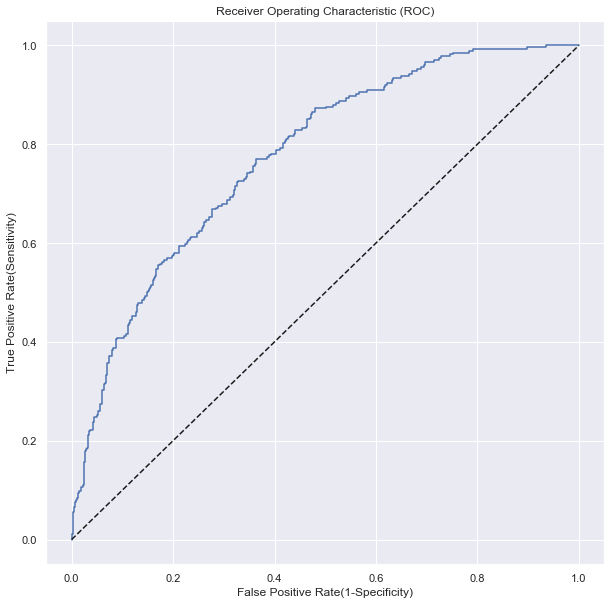

Area under curve (AUC) is: 0.77481


In [22]:
Y = telco_df.copy().churn #preparing data
Y = pd.get_dummies(Y, columns=(['churn']))

fpr, tpr, thresholds = metrics.roc_curve(Y.Yes, opt_log_model.fittedvalues) #calculating ROC curve

J_stats = tpr - fpr #determining optimal threshold using Youden's J Statistic
opt_thresholds = thresholds[np.argmax(J_stats)]
print("Optimal threshold value is: %.5f" %np.exp(opt_thresholds))

plt.figure(figsize=(10, 10)) #plotting ROC curve
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.show()

roc_auc = metrics.auc(fpr, tpr) #calculating area under curve (AUC)
print("Area under curve (AUC) is: %.5f" %roc_auc)



### Part (g)

Recompute the classiﬁcation table, sensitivity and speciﬁcity for the new threshold. Provide interpretation of the obtained values. Compare the results with the original values. Is the procedure now more strict/conservative?


In [23]:
class_table = opt_log_model.pred_table(0.34567) #calculating classification table with new threshold

print("Classification table: \n%s\n" %class_table)

specificity = class_table[1,1] / (class_table[1,1] + class_table[1,0]) #calculate specificity
print("Specificity: %.5f" %specificity)

sensitivity = class_table[0,0] / (class_table[0,0] + class_table[0,1]) #calculate sensitivity
print("Sensitivity: %.5f" %sensitivity)

accuracy = (class_table[0,0] + class_table[1,1]) / (class_table[1,1] + class_table[0,0] + class_table[1,0] + class_table[0,1]) #calculate accuracy
print("Accuracy: %.5f" %accuracy)

misclassification_rate = (class_table[0,1] + class_table[1,0]) / (class_table[1,1] + class_table[0,0] + class_table[1,0] + class_table[0,1]) #calculate misclassification rate
print("Misclassification rate: %.5f" %misclassification_rate)

Classification table: 
[[547. 179.]
 [105. 169.]]

Specificity: 0.61679
Sensitivity: 0.75344
Accuracy: 0.71600
Misclassification rate: 0.28400


In our example with optimal threshold TP=661, FN=179, FP=105 and TN=111.

Sensitivity metric indicates percentage of positive cases which are succesfully predicted as positive. Hence calculated as $\frac{TP}{TP+FN}$. In our example it is $\frac{547}{547+179} = 0.75344$.

Specificity metric indicates percentage of negative cases which are sucesfully predicted as negative. Hence calculated as $\frac{TN}{TN+FP}$. In our example it is $\frac{169}{169+105}=0.61679$.

Accuracy metric indicates percentage of correctly predicted cases. Hence calculated as $\frac{TP+TN}{TP+TN+FP+FN}$. In our example it is $\frac{547+169}{547+169+105+179} = 0.716$.

Misclassification rate metric indicates percentage of incorrectly predicted cases. Hence calcualted as $\frac{FP+FN}{TP+TN+FP+FN}$. In our example it is $\frac{547+169}{547+169+105+179} = 0.284$.

If we compare those metrics with previous classification table we could see that accuracy (amount of correctly predicted cases) gor lowered from 0.772 to 0.716. Subsequently misclassification rate got increased from 0.228 to 0.284. 

Sensitivity got descreased from 0.91047 to 0.75344 which indicates that with new threshold model could predict worse cases when person won't terminate contract.

Specificity on opposite got increased from 0.40511 to 0.61679 which indicates that with new threshold model is much better when predicting clients which will terminate contract. Since our main goal to properly predict client which will terminate contract new threshold definetly improve this skill of the model.

In a nutshell, despite accuracy and sensitivity with new threshold got decreased, specificity got increased which improve model ability to identify clients who will churn, which is our main target. This give us more balanced model - which is equally good at predicting True Positive and True Negative cases - compare to the model with threshold 0.5.

## Subtask 5.

In the next step we model "tenure" using regression trees.

### Part (a)

Assume the ﬁrst variable to be used for splitting is "longmon". Write down the corresponding optimization problem and explain how the optimization works. 

To split our dataset on variable "longmon" we need to find such spliting point $s$ which will minimize objective function $\sum_{i:x_i \in R_1(j,s)} (y_i - \hat y R_1)^2 + \sum_{i:x_i \in R_2(j,s)}(y_i - \hat y R_2)^2$. Here $R_i$ are regions created as result of split and $\hat y R_i$ are averages in regions $R_i$ respectively. Regions are defined as follows $R_1(j, s) = \{X|X_i \le s\}$ and $R_2(j, s) = \{X|X_i \le s\}$.

The goal of optimization is to find such spliting point $s$ which will minimize mean of values $\hat y R_i$ in all regions. Once such spliting point found we form two new regions considering this point. As next step, we recursively split each of regions.

### Part (b)

Obviously you can get very long trees. Tree prunning helps to get trees of a reasonable size. Fit a CART to the data and prune it to have at most 10 splits. What is the value of the corresponding complexity parameter? Check you software for the implementation of the prunning, particularly the form of the loss function.

In [24]:
telco_df_dummy = telco_df.copy() #creating new dataset for regression tree withoun scaling but with dummy variables

telco_df_dummy = pd.get_dummies(telco_df_dummy, columns=(['marital', 'retire', 'gender', 'churn', 'ed'])) #adding dummy variables

telco_df_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', #droping not required dummy variables
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', #renaming remaining ones
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_dummy.head()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
1,13,44,9,64,5,3.70,0.0,1,0,1,1,1,0,0,0
2,11,33,7,136,5,4.40,35.7,1,0,1,1,0,0,0,0
3,68,52,24,116,29,18.15,0.0,1,0,0,0,0,1,0,0
4,33,33,12,33,0,9.45,0.0,0,0,0,1,0,0,1,0
5,23,30,9,30,2,6.30,0.0,1,0,1,0,0,1,0,0


In [25]:
X = telco_df_dummy.copy().drop(columns=['tenure']) #preparing data for decission tree
Y = telco_df_dummy.copy().tenure

tree_regressor = tree.DecisionTreeRegressor(random_state=7) #building and fitting regression tree
tree_regressor.fit(X, Y)
path = tree_regressor.cost_complexity_pruning_path(X, Y) #calculating complexity path
alphas, impurities = path.ccp_alphas, path.impurities

for alpha in alphas: #for each alpha building and fitting a pruned tree by complexity parameter alpha
    clf = tree.DecisionTreeRegressor(random_state=7, ccp_alpha=alpha)
    clf.fit(X, Y)
    print("Number of nodes in the tree: %s." %clf.tree_.node_count, "Complexity parameter alpha = %s" %alpha)

Number of nodes in the tree: 1725. Complexity parameter alpha = 0.0
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of nodes in the tree: 1555. Complexity parameter alpha = 0.0005
Number of

Number of nodes in the tree: 1477. Complexity parameter alpha = 0.001499999999999545
Number of nodes in the tree: 1475. Complexity parameter alpha = 0.0014999999999998864
Number of nodes in the tree: 1471. Complexity parameter alpha = 0.0014999999999999714
Number of nodes in the tree: 1471. Complexity parameter alpha = 0.0014999999999999714
Number of nodes in the tree: 1465. Complexity parameter alpha = 0.0015000000000002273
Number of nodes in the tree: 1465. Complexity parameter alpha = 0.0015000000000002273
Number of nodes in the tree: 1465. Complexity parameter alpha = 0.0015000000000002273
Number of nodes in the tree: 1463. Complexity parameter alpha = 0.0015000000000009095
Number of nodes in the tree: 1461. Complexity parameter alpha = 0.0015428571428571585
Number of nodes in the tree: 1353. Complexity parameter alpha = 0.002
Number of nodes in the tree: 1353. Complexity parameter alpha = 0.002
Number of nodes in the tree: 1353. Complexity parameter alpha = 0.002
Number of nodes i

Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number of nodes in the tree: 1203. Complexity parameter alpha = 0.0045
Number

Number of nodes in the tree: 1019. Complexity parameter alpha = 0.012000000000000455
Number of nodes in the tree: 1017. Complexity parameter alpha = 0.01203333333333334
Number of nodes in the tree: 1015. Complexity parameter alpha = 0.01225
Number of nodes in the tree: 1013. Complexity parameter alpha = 0.012272222222220077
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity parameter alpha = 0.0125
Number of nodes in the tree: 989. Complexity

Number of nodes in the tree: 805. Complexity parameter alpha = 0.03333333333333343
Number of nodes in the tree: 803. Complexity parameter alpha = 0.033333333333334395
Number of nodes in the tree: 801. Complexity parameter alpha = 0.033333333333335304
Number of nodes in the tree: 799. Complexity parameter alpha = 0.033959595959585386
Number of nodes in the tree: 797. Complexity parameter alpha = 0.03413333333333336
Number of nodes in the tree: 795. Complexity parameter alpha = 0.036
Number of nodes in the tree: 793. Complexity parameter alpha = 0.036000000000000004
Number of nodes in the tree: 791. Complexity parameter alpha = 0.036449999999999996
Number of nodes in the tree: 787. Complexity parameter alpha = 0.03673611111111112
Number of nodes in the tree: 785. Complexity parameter alpha = 0.03674999999999909
Number of nodes in the tree: 781. Complexity parameter alpha = 0.036749999999999776
Number of nodes in the tree: 781. Complexity parameter alpha = 0.036749999999999776
Number of n

Number of nodes in the tree: 565. Complexity parameter alpha = 0.09074999999999978
Number of nodes in the tree: 563. Complexity parameter alpha = 0.09074999999999997
Number of nodes in the tree: 561. Complexity parameter alpha = 0.09112499999999976
Number of nodes in the tree: 559. Complexity parameter alpha = 0.09244999999999891
Number of nodes in the tree: 557. Complexity parameter alpha = 0.09338888888889005
Number of nodes in the tree: 553. Complexity parameter alpha = 0.09352430555555549
Number of nodes in the tree: 551. Complexity parameter alpha = 0.0952704391891892
Number of nodes in the tree: 547. Complexity parameter alpha = 0.09558730158730158
Number of nodes in the tree: 545. Complexity parameter alpha = 0.09633333333333348
Number of nodes in the tree: 543. Complexity parameter alpha = 0.0963333333333344
Number of nodes in the tree: 539. Complexity parameter alpha = 0.098
Number of nodes in the tree: 539. Complexity parameter alpha = 0.098
Number of nodes in the tree: 537. 

Number of nodes in the tree: 285. Complexity parameter alpha = 0.27225
Number of nodes in the tree: 283. Complexity parameter alpha = 0.2733749999999996
Number of nodes in the tree: 281. Complexity parameter alpha = 0.28000183150183305
Number of nodes in the tree: 279. Complexity parameter alpha = 0.2801666666666661
Number of nodes in the tree: 277. Complexity parameter alpha = 0.2842177033492832
Number of nodes in the tree: 275. Complexity parameter alpha = 0.28436625557413553
Number of nodes in the tree: 271. Complexity parameter alpha = 0.28968888888888894
Number of nodes in the tree: 269. Complexity parameter alpha = 0.29065934065934007
Number of nodes in the tree: 267. Complexity parameter alpha = 0.29159999999999897
Number of nodes in the tree: 265. Complexity parameter alpha = 0.2925714285714266
Number of nodes in the tree: 263. Complexity parameter alpha = 0.2945333333333342
Number of nodes in the tree: 259. Complexity parameter alpha = 0.3006000000000001
Number of nodes in the

Tree with 10 splits will have 21 node. From text output above we could see that tree with 21 node has complexity parameter $\alpha = 2.023327435787607$. Now building, fitting and visualizing pruned tree.

In [26]:
tree_pruned = tree.DecisionTreeRegressor(random_state=7, ccp_alpha = 2.023327435787607) #building ad fitting tree with complexity parameter alpha
tree_pruned.fit(X, Y)

dot_data = tree.export_graphviz(tree_pruned, feature_names=X.columns, filled=True, rounded=True) #visualizing tree using graphviz
graph = graphviz.Source(dot_data)
graph


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

More intense orange color means bigger value of "tenure" variable in tree node. 

Tree pruning is an algorithm used to prune the tree to avoid over-fitting. It parameterized by $\alpha \ge 0$, which is known as comlexity parameter. Complexity parameter used to define cost-complexity measure $R_\alpha(T)$ of a given tree $T$: $R_\alpha(T) = R(T)+\alpha |T|$, where $|T|$ is a number of terminal nodes in tree $T$ and $R(T)$ is total misclassification rate of the terminal nodes. Minimal cost-complexity pruning finds the subtree of tree $T$ that minmizes $R_\alpha(T)$.

Cost-complexity measure of single node is $R_\alpha(t) = R(t)+\alpha$. Branch $T_t$ defined to be a tree where node $t$ is its root. Depending on $\alpha$, cost-complexity of measure of node $t$ and its branch $T_t$ could be equal. Effective $\alpha$ of the node is such value of $\alpha$ where there are equal, $R_\alpha(T_t) = R_\alpha(t)$. This implies $\alpha_{eff}(t) = \frac{R(t)-R(T_t)}{|T|-1}$. Further, non-terminal node with smalles value of $\alpha_{eff}(t)$ is the weakest link and will be pruned. This process stops when pruned tree's minimal $\alpha_{eff}(t)$ is greater than value passed as parameter ccp_alpha.

### Part (c)

Check the value of the improvement in the ﬁrst split. Explain the idea of improvement and provide numerical expression how this improvement is computed for the ﬁrst split. 

Impovement of split is the ratio of the error before split compared with total error after split. It allow us to judge if split improves a model or not and if improves - we could quantify it by using improvement. 

Let assume we have root node 1 and two child notes 2 and 3 - left and right childrens. Also, let denote number of observation in each node as $K_i$: $K_1$, $K_2$ and $K_3$ respectively. Now, we could calculate mean squared error (MSE) of each node using number of observation in node $K_i$ and average value of node $\hat y_{Node i}$.

Node 1: $MSE_1 = \frac{1}{K_1} \sum_{i=1}^{K_1}(y_i - \hat y_{Node 1})^2$ <br>
Node 2: $MSE_2 = \frac{1}{K_2} \sum_{i=1}^{K_2}(y_i - \hat y_{Node 2})^2$ <br>
Node 1: $MSE_3 = \frac{1}{K_3} \sum_{i=1}^{K_3}(y_i - \hat y_{Node 3})^2$ <br>

Once we know all MSE scores we could calculate improvemen itself by using formula below: <br>
$Improvement = \frac{MSE_1*K_1 - (MSE_2*K_2 + MSE_3*K_3)}{MSE_1*K_1}$.

In or particular case we have following error values and number of observations for first split (values taken from tree visalization above): <br>
$MSE_1 = 455.785$ and $K_1=1000$ <br>
$MSE_2 = 199.361$ and $K_2=565$ <br>
$MSE_3 = 202.252$ and $K_3=435$ <br>

As final step we could calculate an improvement of first split now.

In [27]:
mse1, mse2, mse3 = 455.785, 199.361, 202.252 #setting initial values
k1, k2, k3 = 1000, 565, 435

improvement = (mse1 * k1 - (mse2 * k2 + mse3 * k3))/(mse1 * k1) #calculating improvement

print("Improvement of first split is", "{:.2%}".format(improvement)) #printing improvements

Improvement of first split is 55.98%


### Part (d)

Compare the in-sample ﬁt of the tree to the in-sample ﬁt of the lasso regression above. Compare the importance of the variables for the two models. In the case of the lasso regression the importance is mirrored by the parameters if the variables are standardized.


In-sample fit means that we are fitting same data which were used for training. This means thare is no separate test dataset which was excluded from training. Hence we could run Lasso regression and our Decision Tree Regression on whole dataset available to us. This action was already performed, hence I will just collect results and compare $R^2$ score and RMSE of both models.

In [28]:
X_tree = telco_df_dummy.copy().drop(columns=['tenure']) #preparing data for decission tree
Y_tree = telco_df_dummy.copy().tenure

X_lasso = telco_df_norm_dummy.copy().drop(columns=['tenure']) #preparing data for Lasso CV
Y_lasso = telco_df_norm_dummy.copy().tenure

lasso_rmse = np.sqrt(((Y_lasso - lassoCV.predict(X_lasso))**2).mean()) #calculating Lasso RMSE

tree_rmse = np.sqrt(((Y_tree - tree_pruned.predict(X_tree))**2).mean()) #calculating Decision Tree RMSE

print("R2 score of Lasso CV model is %.6f" %lassoCV.score(X_lasso, Y_lasso)) #printing results
print("RMSE of Lasso CV model is %.6f\n" %lasso_rmse)

print("R2 score of pruned tree is %.6f" %tree_pruned.score(X_tree, Y_tree))
print("RMSE of pruned tree is %.6f" %tree_rmse)

R2 score of Lasso CV model is 0.620212
RMSE of Lasso CV model is 0.615961

R2 score of pruned tree is 0.757061
RMSE of pruned tree is 10.522739


As we could see from results above Lasso model has lower $R^2$ score, however at the same time, it has better in-sample fit because it's RMSE is much lower compare to Regression Tree RMSE. I think pruned decision tree couldn't give better RMSE, than Lasso CV model because of the way how values predicted for the tree - it is mean value of all points belonging to same node. For in-sample fit it's only possible if tree will be overfitted, but it will generalize badly in such case.

In [29]:
print("Importance of variables...\n")
print("for Lasso CV:")
for i in range (0, 14): #printing importance list of Lasso CV based on models coefficients
  print("Improtance of feature \"%s\"" %X_lasso.columns[i], "is %.6f" %lassoCV.coef_[i]) 

print("\nfor Decision Tree:")
for i in range (0, 14): #printing importance list of Decision Tree using respective attribute of model
  print("Improtance of feature \"%s\"" %X_tree.columns[i], "is %.6f" %tree_pruned.feature_importances_[i])


Importance of variables...

for Lasso CV:
Improtance of feature "age" is 0.096733
Improtance of feature "address" is 0.142701
Improtance of feature "income" is -0.000000
Improtance of feature "employ" is 0.117339
Improtance of feature "longmon" is 0.511640
Improtance of feature "wiremon" is 0.059542
Improtance of feature "marital_dummy" is 0.064636
Improtance of feature "retire_dummy" is -0.081615
Improtance of feature "gender_dummy" is -0.002702
Improtance of feature "churn_dummy" is -0.145199
Improtance of feature "ed_dummy_college_degree" is -0.008841
Improtance of feature "ed_dummy_no_high_school" is 0.000000
Improtance of feature "ed_dummy_high_school" is -0.000000
Improtance of feature "ed_dummy_some_college" is -0.000000

for Decision Tree:
Improtance of feature "age" is 0.000000
Improtance of feature "address" is 0.012474
Improtance of feature "income" is 0.000000
Improtance of feature "employ" is 0.032833
Improtance of feature "longmon" is 0.946075
Improtance of feature "wirem

Now we could compare feature importance for Lasso CV model and pruned Regression Tree. I took data from result above and ranked it in the tables below.

For Lasso CV:

| Feature | Importance Rank |
|------|------|
| longmon | 1 |
| churn_dummy | 2 |
| address | 3 |
| employ | 4 |
| age | 5 |
| retire_dummy | 6 |
| marital_dummy | 7 |
| wiremon | 8 |
| ed_dummy_college_degree | 9 |
| gender_dummy | 10 |

For Regression Tree: 

| Feature | Importance Rank |
|------|------|
| longmon | 1 |
| employ | 2 | 
| address | 3 |
| churn_dummy | 4 |

From those table we could see that tree definetly use much less number of features - 4 compare to 10. Also we could see that for both models most important feature is "longmon". In fact, for tree this feature extreamly important - 94.6%. This indicates that a lot of splits both primary and surrogates were done using "longmon". Importance of features "employ" and "address" are swapped in Lasso CV and Regression Tree ranks. And feature "churn_dummy" for Lasso CV model has second priority, while for Regression Tree it has last priority in the list of important variables. If we wouldn't take into account specific order of variables in importance list of Lasso CV and Regression Tree models, we could notice that first four places in both lists are occupied by same variables. Those variables are "longmon", "employ", "churn_dummy" and "address". Which indicates that in geneal those four features has the biggest impact on modeling "tenure" as dependent variable.

In addition to above Lasso CV model includes such features as "age", retire_dummy", "marital_dummy", "wiremon", "ed_dummy_college_degree" and "gender_dummy" which are not present in Decision Tree model.



